# Multi-Planar U-Net for Cell Mask prediction

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import nibabel as nib
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display
import pickle
from scipy import ndimage
import numpy as np
from iou_track import *
from glob import glob
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
lbl_cmap = random_label_cmap()

## 0. Load data

In [2]:
import h5py

path = 'data/GT/'
f = h5py.File(path+'GT_TrackID.h5','r+') # Track file
track = f['image'][:]
f.close()

f = h5py.File(path+'Plantseg_T29-39.h5','r+') # PlantSeg file
plantseg = f['image'][:]
f.close()

f = h5py.File(path+'C1mem_T29-39.h5','r+') # Raw file
c1 = f['image'][:]
f.close()

f = h5py.File(path+'C2ZO1_T29-39.h5','r+') # C2 file
c2 = f['image'][:]
f.close()

### Prepare data

#### Sliced

In [70]:
## Slice size
max_t, *_ = c2.shape
#slice_z = [0, 20]
#slice_y = [0, 100]
#slice_x = [0, 100]

slice_z = [5]
slice_y = [50]
slice_x = [50]

## Erode kernel
kernel = np.ones((1, 3, 3), np.uint8) # Erode Z,Y,X

for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                subpath = path+'/mpunet2/'

                _c1 = c1[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _c2 = c2[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _plantseg = plantseg[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                
                #_X = np.stack((_c1, _c2, _plantseg), axis=3)
                

                # Turn Y into eroded binary mask
                _f = track[_t, _z:_z+20, _y:_y+100, _x:_x+100].astype(np.int32)
                _Y = np.zeros(_f.shape)
                for g in np.unique(_f):
                    if g==0: continue
                    _mask = mask(_f, g)
                    _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
                    _Y = _Y + _mask2
                _Y = _Y.astype(np.int32)
                                
                #_f = h5py.File(path+file, 'w') # Track file
                #_f.create_dataset('X', data=_X)
                #_f.create_dataset('Y', data=_Y)
                #_f.close()
                #affine = np.eye(4)
                im_path = subpath+'images/%s.nii.gz' % ext
                lab_path = subpath+'labels/%s.nii.gz' % ext
                affine = np.eye(4)
                nib.save(nib.Nifti1Image(_X, affine=affine), im_path)
                nib.save(nib.Nifti1Image(_Y, affine=affine), lab_path)

#### Not sliced

In [77]:
## Erode kernel
kernel = np.ones((1, 3, 3), np.uint8) # Erode Z,Y,X
max_t, *_ = c2.shape
for _t in range(max_t):
    ext = 'T%s' % (_t)
    subpath = path+'/mpunet4/'

    _c1 = c1[_t, :,:,:]
    _c2 = c2[_t, :,:,:]
    _plantseg = plantseg[_t, :,:,:]
    
    #_X = np.stack((_c1, _c2, _plantseg), axis=3)
    _X = _c1

    # Turn Y into eroded binary mask
    _f = track[_t, :,:,:].astype(np.int32)
    _Y = np.zeros(_f.shape)
    for g in np.unique(_f):
        if g==0: continue
        _mask = mask(_f, g)
        _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
        _Y = _Y + _mask2
    _Y = _Y.astype(np.int32)
                    
    im_path = subpath+'images/%s.nii.gz' % ext
    lab_path = subpath+'labels/%s.nii.gz' % ext
    
    affine = np.eye(4)
    nib.save(nib.Nifti1Image(_X, affine=affine), im_path)
    nib.save(nib.Nifti1Image(_Y, affine=affine), lab_path)

#### Create unseen dataset

In [283]:
path2 = '/Volumes/Storage/thesis_data/fate-predict-datasets/Alice/raw-data'
files = sorted(glob(path2+'/*_T2*_predictions_fused.h5'))[0:-1]
for t, f in enumerate(files):
    _f = h5py.File(f,'r+') # Track file
    _plantseg = _f['fused_data'][3, 10:53, 50:250, 50:251]
    _c1 = _f['fused_data'][0, 10:53, 50:250, 50:251]
    _f.close()

    ext = 'T%s' % (t)
    affine = np.eye(4)
    nib.save(nib.Nifti1Image(_plantseg, affine=affine), 'data/mpunet_unseen_plantseg/images/%s.nii.gz' % ext)
    nib.save(nib.Nifti1Image(_c1, affine=affine), 'data/mpunet_unseen_c1/images/%s.nii.gz' % ext)

#### Load predictions

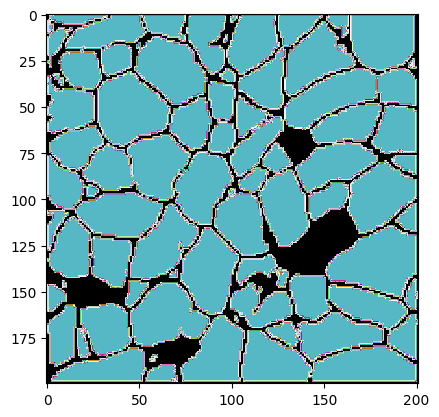

In [20]:
from skimage import measure
from skimage import filters

def label(image, kernel=np.ones((1, 3, 3), np.uint8)):
    #image = ndimage.binary_erosion(image, structure=kernel) 
    all_labels = measure.label(image)
    blobs_labels = measure.label(image, background=0)
    
    return blobs_labels
    
def load_predictions(path):
    _path = path+'/*_PRED.nii.gz'
    files = sorted(glob(_path))
    pred = np.zeros(c1.shape, dtype=int)
    for t, f in enumerate(files):
        img = nib.load(f)
        pred[t] = label(img.dataobj)
        
    return pred

Y_pred = load_predictions('data/GT/mpunet3/pred/')
plt.imshow(Y_pred[0, 20], cmap=lbl_cmap)

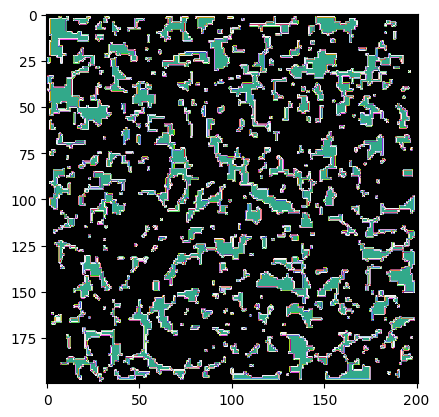

In [13]:
Y_pred = load_predictions('data/mpunet3_unseen_pred')
plt.imshow(Y_pred[5, 20], cmap=lbl_cmap)

In [8]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset([track], [Y_pred], thresh=t, show_progress=False) for t in tqdm(taus)]

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


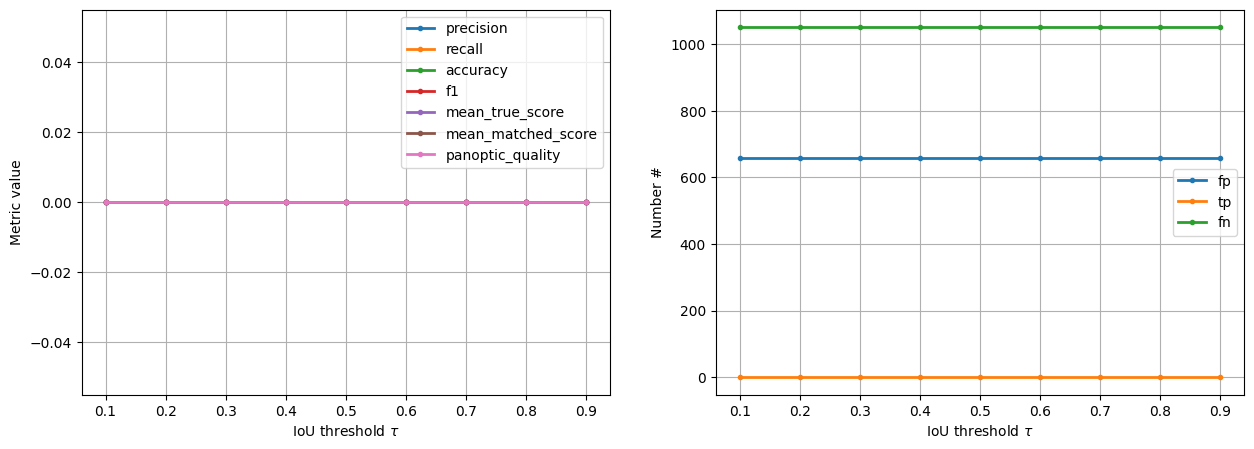

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

plt.savefig('exp8.1_multiplanar_mask_labeled.png')

In [57]:
import napari

viewer = napari.Viewer()
viewer.add_image(X[0][:,:,:,0], name='Membranes')
viewer.add_image(X[0][:,:,:,1], name='ZO1')
viewer.add_image(X[0][:,:,:,2], name='PlantSeg')
viewer.add_labels(Y[0], name='Labels')

<Labels layer 'Labels' at 0x11a9c9a30>

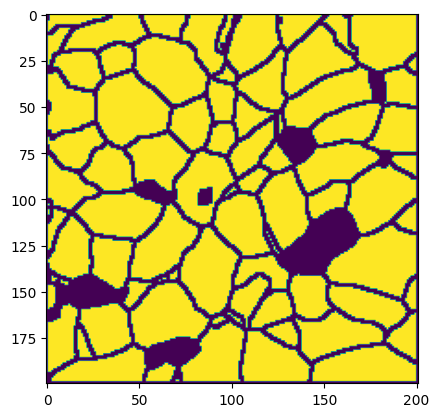

In [22]:
img = nib.load('data/GT/mpunet4/labels/T0.nii.gz')
plt.imshow(img.dataobj[20])

In [87]:
!ls -l data/GT/mpunet2/images/

total 25120
-rw-r--r--  1 daniel  staff  1171963 Dec 17 01:31 T0_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1165509 Dec 17 01:31 T10_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1170256 Dec 17 01:31 T1_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1169172 Dec 17 01:31 T2_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1167564 Dec 17 01:31 T3_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1166635 Dec 17 01:31 T4_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1166648 Dec 17 01:31 T5_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1167490 Dec 17 01:31 T6_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1163708 Dec 17 01:31 T7_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1166234 Dec 17 01:31 T8_Z0_Y0_X0.nii.gz
-rw-r--r--  1 daniel  staff  1162738 Dec 17 01:31 T9_Z0_Y0_X0.nii.gz
